<div align='center'><font size="5" color='#353B47'>Predicting Stock Prices</font></div>
<div align='center'><font size="4" color="#353B47">How to use LSTMs</font></div>
<br>
<hr>

## <div id="summary">Summary</div>

**<font size="2"><a href="#chap1">1. Import libraries</a></font>**
**<br><font size="2"><a href="#chap2">2. Preprocessing</a></font>**
**<br><font size="2"><a href="#chap3">3. Build LSTM model</a></font>**
**<br><font size="2"><a href="#chap4">4. Training</a></font>**
**<br><font size="2"><a href="#chap5">5. Predictions</a></font>**

# Imports

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Pre-Processing

In [2]:
# Load csv
no_process_df = pd.read_csv('CAC40_stock_data.csv', parse_dates=['Date'])
no_process_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
27715,2023-12-06,12.690,13.405,12.585,13.125,13.125,1736300.0,FR.PA
27716,2023-12-07,12.960,13.860,12.740,13.850,13.850,3284833.0,FR.PA
27717,2023-12-08,13.750,14.535,13.705,14.300,14.300,2690703.0,FR.PA
27718,2023-12-11,14.300,14.325,13.900,14.015,14.015,1223682.0,FR.PA
27719,2023-12-12,14.005,14.005,13.240,13.255,13.255,1806853.0,FR.PA


In [3]:
df = pd.DataFrame()

# Extract relevant columns from the original DataFrame
df['Unnamed: 0'] = no_process_df.index  # Adding an index as 'Unnamed: 0'
df['Name'] = no_process_df['Stock']
df['Date'] = no_process_df['Date']
df['Open'] = no_process_df['Open']
df['Closing_Price'] = no_process_df['Close']
df['Daily_High'] = no_process_df['High']
df['Daily_Low'] = no_process_df['Low']
df['Volume'] = no_process_df['Volume']

# Reverse the order of rows if necessary (optional)
#new_df = new_df[::-1].reset_index(drop=True)



In [4]:
df = df[::-1].reset_index(drop=True)


In [5]:
df

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,27719,FR.PA,2023-12-12,14.005,13.255000,14.005000,13.240000,1806853.0
1,27718,FR.PA,2023-12-11,14.300,14.015000,14.325000,13.900000,1223682.0
2,27717,FR.PA,2023-12-08,13.750,14.300000,14.535000,13.705000,2690703.0
3,27716,FR.PA,2023-12-07,12.960,13.850000,13.860000,12.740000,3284833.0
4,27715,FR.PA,2023-12-06,12.690,13.125000,13.405000,12.585000,1736300.0
...,...,...,...,...,...,...,...,...
27715,4,AC.PA,2020-12-18,29.580,29.540001,30.100000,29.340000,1033501.0
27716,3,AC.PA,2020-12-17,29.750,29.770000,30.000000,29.480000,677096.0
27717,2,AC.PA,2020-12-16,30.230,29.629999,30.400000,29.360001,650601.0
27718,1,AC.PA,2020-12-15,29.430,29.990000,30.030001,29.010000,1116363.0


In [6]:
COMPANY = 'AC.PA'
START_DATE = dt.datetime.now() - dt.timedelta(days=365*4)
END_DATE = dt.datetime.now()  - dt.timedelta(days=365)

START_DATE_TEST = dt.datetime.now()  - dt.timedelta(days=365)

In [7]:
def load_data(company, start, end):
    dataframe = df.copy()
    print("Original DataFrame:")
    print(dataframe.info())

    dataframe = dataframe.loc[dataframe.Name == company, :]
    print(f"Filtered by Company ({company}):")
    print(dataframe.info())

    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    print(f"Filtered by Date Range ({start} to {end}):")
    print(dataframe.info())

    dataframe = dataframe.rename(columns={'Closing_Price': 'Close'})
    return dataframe


data = load_data(company=COMPANY, start=START_DATE, end=END_DATE)
print("Loaded Data:")
print(data.info())


Original DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     27720 non-null  int64         
 1   Name           27720 non-null  object        
 2   Date           27720 non-null  datetime64[ns]
 3   Open           27720 non-null  float64       
 4   Closing_Price  27720 non-null  float64       
 5   Daily_High     27720 non-null  float64       
 6   Daily_Low      27720 non-null  float64       
 7   Volume         27720 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.7+ MB
None
Filtered by Company (AC.PA):
<class 'pandas.core.frame.DataFrame'>
Int64Index: 770 entries, 26950 to 27719
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     770 non-null   

In [8]:
START_DATE

datetime.datetime(2020, 2, 6, 2, 38, 7, 26312)

In [9]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 553 entries, 27167 to 27719
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  553 non-null    int64         
 1   Name        553 non-null    object        
 2   Date        553 non-null    datetime64[ns]
 3   Open        553 non-null    float64       
 4   Close       553 non-null    float64       
 5   Daily_High  553 non-null    float64       
 6   Daily_Low   553 non-null    float64       
 7   Volume      553 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 38.9+ KB
None


In [10]:
data

,Unnamed: 0,Name,Date,Open,Close,Daily_High,Daily_Low,Volume
27167,552,AC.PA,2023-02-03,30.740000,31.090000,31.090000,30.610001,696597.0
27168,551,AC.PA,2023-02-02,30.129999,30.799999,30.959999,30.129999,790317.0
27169,550,AC.PA,2023-02-01,29.860001,29.920000,30.299999,29.840000,652883.0
27170,549,AC.PA,2023-01-31,29.799999,29.770000,29.860001,29.549999,809918.0
27171,548,AC.PA,2023-01-30,29.760000,29.700001,29.860001,29.379999,549040.0
...,...,...,...,...,...,...,...,...
27715,4,AC.PA,2020-12-18,29.580000,29.540001,30.100000,29.340000,1033501.0
27716,3,AC.PA,2020-12-17,29.750000,29.770000,30.000000,29.480000,677096.0
27717,2,AC.PA,2020-12-16,30.230000,29.629999,30.400000,29.360001,650601.0
27718,1,AC.PA,2020-12-15,29.430000,29.990000,30.030001,29.010000,1116363.0


In [11]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))


In [13]:
# Set the number of days used for prediction
prediction_days = 60

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [14]:
x_train

array([[[0.70298412],
        [0.68285914],
        [0.6217905 ],
        ...,
        [0.31020134],
        [0.29840397],
        [0.30464964]],

       [[0.68285914],
        [0.6217905 ],
        [0.61138109],
        ...,
        [0.29840397],
        [0.30464964],
        [0.26231789]],

       [[0.6217905 ],
        [0.61138109],
        [0.60652337],
        ...,
        [0.30464964],
        [0.26231789],
        [0.22553782]],

       ...,

       [[0.97779322],
        [0.96391392],
        [0.94517716],
        ...,
        [0.53296325],
        [0.59541998],
        [0.61138109]],

       [[0.96391392],
        [0.94517716],
        [0.9729355 ],
        ...,
        [0.59541998],
        [0.61138109],
        [0.60166552]],

       [[0.94517716],
        [0.9729355 ],
        [0.95836235],
        ...,
        [0.61138109],
        [0.60166552],
        [0.62664822]]])

# LSTM model

In [15]:
def LSTM_model():

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

# Training

In [16]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 

In [17]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

model.fit(
    x_train, 
    y_train, 
    epochs=9, 
    batch_size = 32,
    callbacks = [checkpointer],
    validation_split=0.2
)

Epoch 1/9

13/13 [==============================] - ETA: 0s - loss: 0.1062
Epoch 1: val_loss improved from inf to 0.03747, saving model to weights_best.hdf5
13/13 [==============================] - 6s 145ms/step - loss: 0.1062 - val_loss: 0.0375
Epoch 2/9
 1/13 [=>............................] - ETA: 0s - loss: 0.0287

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/13 [==========================>...] - ETA: 0s - loss: 0.0294
Epoch 2: val_loss improved from 0.03747 to 0.01360, saving model to weights_best.hdf5
13/13 [==============================] - 1s 56ms/step - loss: 0.0292 - val_loss: 0.0136
Epoch 3/9
13/13 [==============================] - ETA: 0s - loss: 0.0229
Epoch 3: val_loss did not improve from 0.01360
13/13 [==============================] - 1s 42ms/step - loss: 0.0229 - val_loss: 0.0139
Epoch 4/9
13/13 [==============================] - ETA: 0s - loss: 0.0180
Epoch 4: val_loss improved from 0.01360 to 0.01273, saving model to weights_best.hdf5
13/13 [==============================] - 1s 53ms/step - loss: 0.0180 - val_loss: 0.0127
Epoch 5/9
13/13 [==============================] - ETA: 0s - loss: 0.0224
Epoch 5: val_loss improved from 0.01273 to 0.01188, saving model to weights_best.hdf5
13/13 [==============================] - 1s 52ms/step - loss: 0.0224 - val_loss: 0.0119
Epoch 6/9
13/13 [==============================] - ETA: 0

In [18]:
data

,Unnamed: 0,Name,Date,Open,Close,Daily_High,Daily_Low,Volume
27167,552,AC.PA,2023-02-03,30.740000,31.090000,31.090000,30.610001,696597.0
27168,551,AC.PA,2023-02-02,30.129999,30.799999,30.959999,30.129999,790317.0
27169,550,AC.PA,2023-02-01,29.860001,29.920000,30.299999,29.840000,652883.0
27170,549,AC.PA,2023-01-31,29.799999,29.770000,29.860001,29.549999,809918.0
27171,548,AC.PA,2023-01-30,29.760000,29.700001,29.860001,29.379999,549040.0
...,...,...,...,...,...,...,...,...
27715,4,AC.PA,2020-12-18,29.580000,29.540001,30.100000,29.340000,1033501.0
27716,3,AC.PA,2020-12-17,29.750000,29.770000,30.000000,29.480000,677096.0
27717,2,AC.PA,2020-12-16,30.230000,29.629999,30.400000,29.360001,650601.0
27718,1,AC.PA,2020-12-15,29.430000,29.990000,30.030001,29.010000,1116363.0


# Inference 

In [19]:
# Load test data for the specified company and date range
test_data = load_data(
    company=COMPANY,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

print(len(total_dataset))
print(len(test_data))
print(prediction_days)
# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)


Original DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     27720 non-null  int64         
 1   Name           27720 non-null  object        
 2   Date           27720 non-null  datetime64[ns]
 3   Open           27720 non-null  float64       
 4   Closing_Price  27720 non-null  float64       
 5   Daily_High     27720 non-null  float64       
 6   Daily_Low      27720 non-null  float64       
 7   Volume         27720 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.7+ MB
None
Filtered by Company (AC.PA):
<class 'pandas.core.frame.DataFrame'>
Int64Index: 770 entries, 26950 to 27719
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     770 non-null   

In [20]:
prediction_days

60

In [21]:
len(model_inputs)

277

In [22]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    
    #print(model_inputs[x-prediction_days:x, 0])
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])


    
# Convert the x_test list to a numpy array
x_test = np.array(x_test)
print(x_test)
print("x_test shape: ", x_test.shape)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

[[0.9729355  0.95836235 0.91394879 ... 0.60166552 0.62664822 0.59125611]
 [0.95836235 0.91394879 0.95836235 ... 0.62664822 0.59125611 0.99097868]
 [0.91394879 0.95836235 0.97362961 ... 0.59125611 0.99097868 0.9729355 ]
 ...
 [0.77654424 0.77793194 0.74947962 ... 0.62317846 0.59195009 0.6821653 ]
 [0.77793194 0.74947962 0.75503131 ... 0.59195009 0.6821653  0.69743243]
 [0.74947962 0.75503131 0.76405277 ... 0.6821653  0.69743243 0.67036793]]
x_test shape:  (217, 60)
7/7 [==============================] - 1s 12ms/step


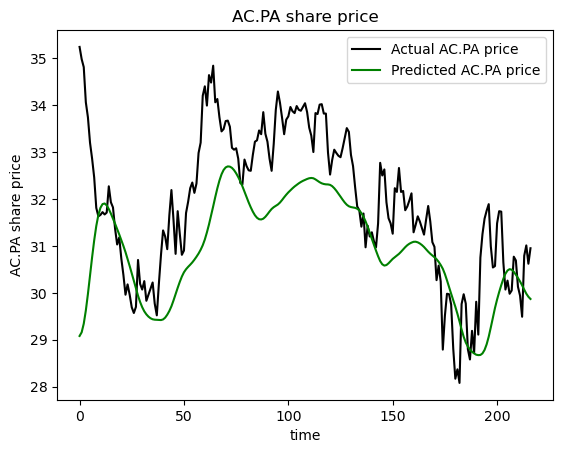

In [23]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")

# Set the title of the plot using the company name
plt.title(f"{COMPANY} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{COMPANY} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [37]:
# Extract the last 'prediction_days' values from the model inputs
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

real_data_vis = scaler.inverse_transform(real_data[0])

real_data_vis[0][0]

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")
print(f"real: {real_data_vis[0][0]}")

1/1 [==============================] - 0s 47ms/step
Prediction: 29.84441375732422
real: 31.96999931335449


# References

* <a href = 'https://www.kaggle.com/bryanb'>Based on work done by Brynab</a>
* <a href = 'http://colah.github.io/posts/2015-08-Understanding-LSTMs/'>LSTM Explanations</a>